
# Introduction to PyTorch

PyTorch is a Python-based scientific computing package targeted at two sets of audiences:

-  A replacement for NumPy to use the power of GPUs,
-  a deep learning research platform that provides maximum flexibility
   and speed.

# 1. Tensors

Tensors are similar to NumPy’s ndarrays, with the addition being that
Tensors can also be used on a GPU to accelerate computing.

In [ ]:
# Optional, uncomment to install PyTorch

# import sys
# !{sys.executable} -m pip install torch torchvision

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline

## 1.1 Construct Tensors

Tensors can be constructed by constructors given disired shapes and data types.

In [ ]:
x = torch.empty(5, 3)
print(x)

In [ ]:
x = torch.rand(5, 3)
print(x)

In [ ]:
x = torch.zeros(5, 3, dtype=torch.long)
print(x)

Tensors can also be created from Python lists, NumPy arrays and other tensors.

In [ ]:
# Create a tensor from a Python list.
x = torch.tensor([5.5, 3])
print(x)

In [ ]:
# Create a tensor from a NumPy array.
x = torch.tensor(np.random.randn(5, 3))
print(x)

In [ ]:
# Create a tensor from an existing tensor.
x = x.new_ones(5, 3)      # new_* methods take in sizes
print(x)

x = torch.randn_like(x)
print(x)                  # result has the same size

## 1.2 Tensor Operations

In [ ]:
# Create two simple tensors for illustration.
x = torch.zeros(5, 3)
y = torch.ones(5, 3)

In [ ]:
# Basic arithmatic operations
print(x + y)
print(x * y)

In [ ]:
# Specify output
result = torch.empty(5, 3)
torch.add(x, y, out=result)
print(result)

In [ ]:
# In-place add x to y
y.add_(x)
print(y)

In [ ]:
# You can use standard NumPy-like indexing with all bells and whistles!
print(x[:, 1])

Resizing: If you want to resize/reshape tensor, you can use ``torch.view``:



In [ ]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

If you have a one element tensor, use ``.item()`` to get the value as a
Python number



In [ ]:
x = torch.randn(1)
print(x)
print(x.item())

## 1.3 NumPy Bridge

Converting a PyTorch `Tensor` to a NumPy `Array` and vice versa is a breeze.

The PyTorch `Tensor` and NumPy `Array` share their underlying memory (if the Torch Tensor is on CPU). Thus changing one will change the other.

Converting a PyTorch `Tensor` to a NumPy `Array`.

In [ ]:
a = torch.ones(5)
print(a)

b = a.numpy()
print(b)

The NumPy `Array` is changed with the PyTorch `Tensor`.

In [ ]:
a.add_(1)
print(a)
print(b)

Converting NumPy `Array` to PyTorch `Tensor`. The PyTorch `Tensor` is changed with the NumPy `Array`.

In [ ]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

# 2. Autograd: Automatic Differentiation


Central to all neural networks in PyTorch is the ``autograd`` package.
The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

## 2.1 Tensor

``torch.Tensor`` is the central class of the package. If the attribute ``.requires_grad`` is set as ``True``, it starts to track all operations on that tensor.
To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

There’s one more class which is very important for autograd
implementation - a ``Function``.
``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

Create a tensor and set ``requires_grad=True`` to track computation with it.

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

In [ ]:
y = x + 2
print(y)

``y`` was created as a result of an operation, so it has a ``grad_fn``.

In [ ]:
z = y * y * 3
print(z)

## 2.2 Gradients

When you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

In [ ]:
out = z.mean()
print(out)

Print $\nabla_x out$.
The result should be a matrix of 4.5.

Because $out = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.

Therefore,
$\frac{\partial out}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial out}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.

In [ ]:
out.backward()
print(x.grad)

# 3. MNIST Image Classification

This section will build a neural network to classify the MNIST dataset. The neural network is based on LeNet-5 \[LeCun et al., 1998\], which is one of the earliest neural networks.

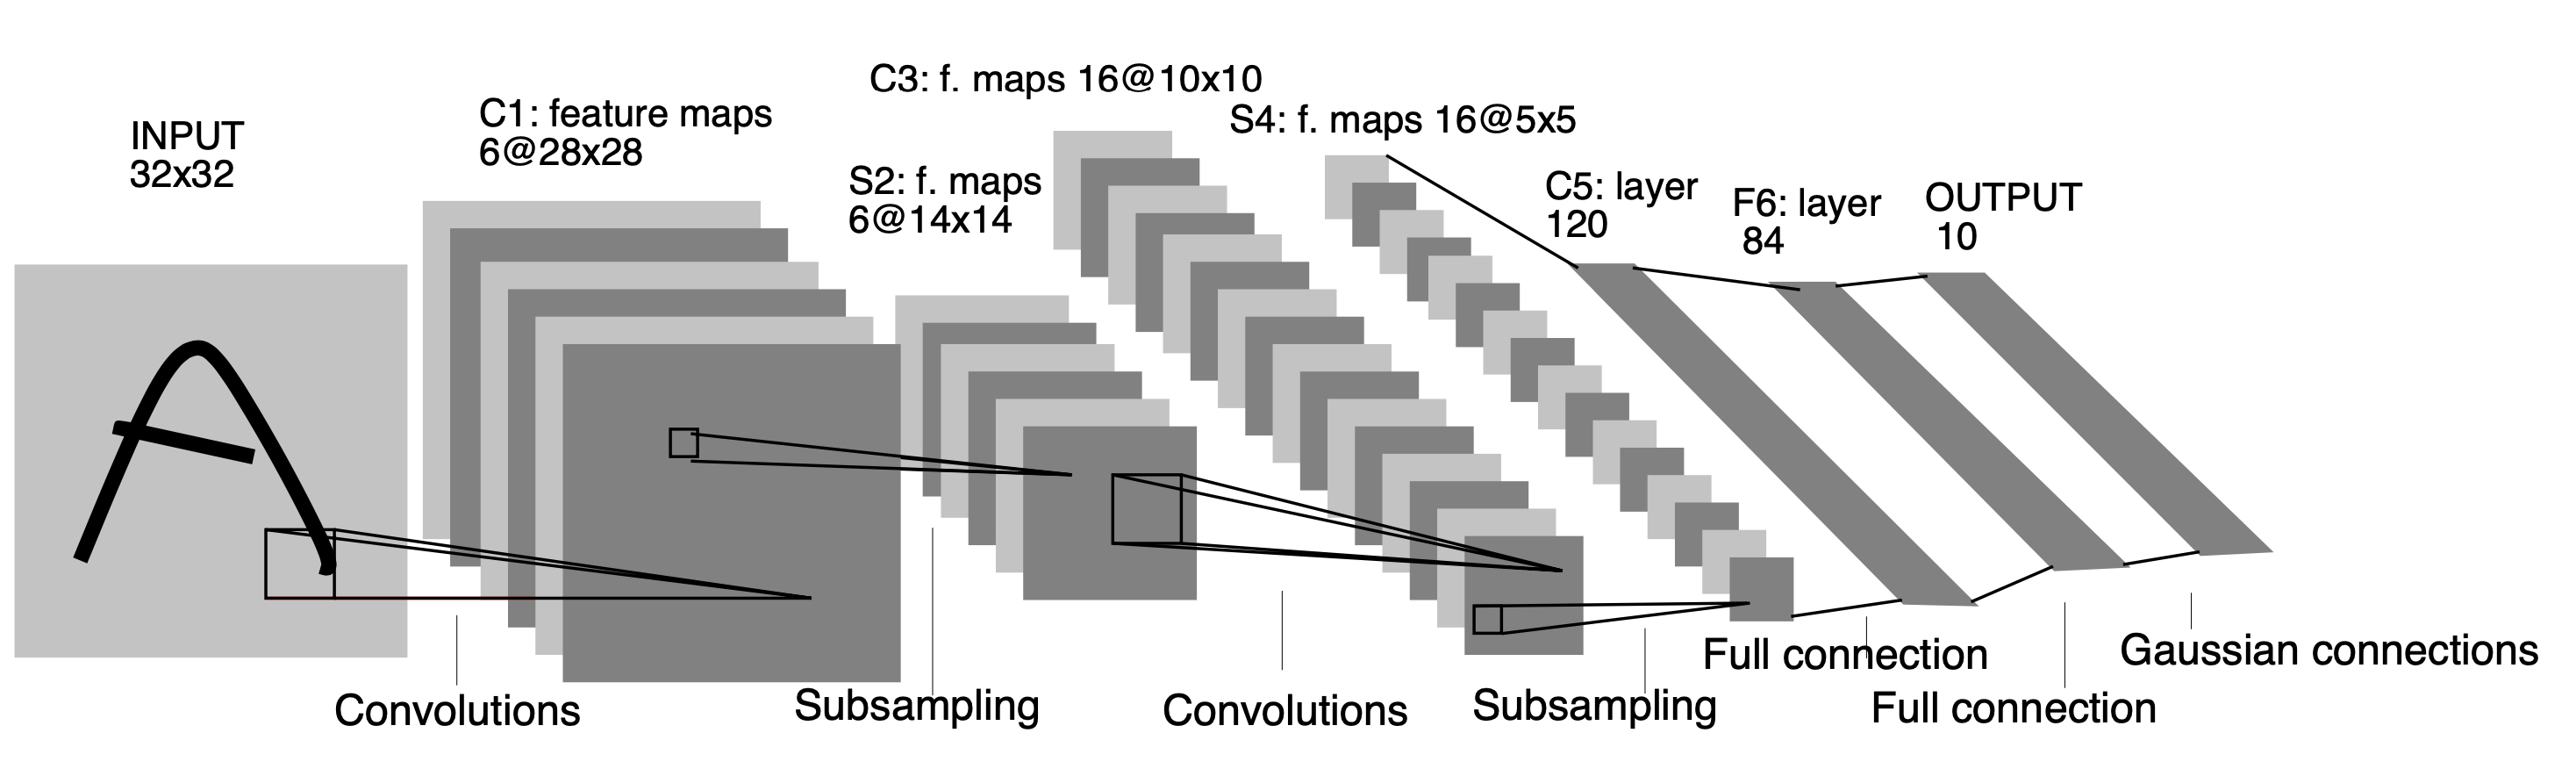
The structure of LeNet-5 \[LeCun et al., 1998\].

## 3.1 Preparation

First, fix the random seed and define hyperparameters.

In [ ]:
import numpy as np
import torch

np.random.seed(0)
torch.manual_seed(0)

num_epochs = 5     # number of times which the entire dataset is passed throughout the model
batch_size = 64    # the size of input data took for one iteration
lr = 0.01          # learning rate
momentum = 0.9     # momentum

Load MNIST dataset. If data does not exist, PyTorch will download it automatically. `transform` is the data preprocessing module, it will convert the data into tensors, and then normalize according to the given values.

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST(root='./data',
                            train=True,
                            transform=transform,
                            download=True)

test_data = datasets.MNIST(root='./data',
                           train=False,
                           transform=transform)

The dataloader provides a Python iterable over a dataset, with support for

- map-style and iterable-style datasets,

- customizing data loading order,

- automatic batching,

- single- and multi-process data loading,

- distributed data loading,

- automatic memory pinning.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size, 
                         shuffle=False)

Then, we visualize some data from the test set.

In [ ]:
_, (example_data, example_targets) = next(enumerate(test_loader))

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title("Ground Truth: %d" % example_targets[i])
    plt.xticks([])
    plt.yticks([])

## 3.2 Build the Neural Network

`Net` class extends `nn.Module` class, which is the base class for all neural network modules. `__init__` function creates needed layers, `forward` function describes how these layers are applied to inputs.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

net = Net()

If GPU is available, move the model to GPU.

In [ ]:
if torch.cuda.is_available():
    net.cuda()

Print details of the model. `net.parameters()` returns a iterable of all parameters of `net` instance. Convelution layers and fully connected layers each has a weight tensor and a bias tensor, so the total number of parameters is 8.

In [ ]:
print(net)

params = list(net.parameters())
print('There are %d parameters' % len(params))
print(params[0].size())  # conv1's weights

Define loss-function and optimizer.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

## 3.3 Training

Define two utility functions first. `torch.no_grad` can be used as a decorator or context manager to disable history tracking.

In [ ]:
# Compute the accuracy
@torch.no_grad()
def accuracy(outputs, labels):
    pred = outputs.data.max(1, keepdim=True)[1]
    return pred.eq(labels.data.view_as(pred)).cpu().float().mean()

# Evaluate the model on test set
@torch.no_grad()
def test(net):
    accs = []
    losses = []
    net.eval()
    for images, labels in test_loader:

        # If GPU is available, move data to GPU
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)
        losses.append(criterion(outputs, labels))
        accs.append(accuracy(outputs, labels))

    net.train()

    acc = sum(accs) / len(accs)
    loss = sum(losses) / len(losses)
    
    return loss, acc

Trainig model. Accuracy and loss are saved for both train and test.

In [ ]:
#@title Training the model
train_loss = []
train_acc = []

test_results = test(net)
test_loss = [test_results[0]]
test_acc = [test_results[1]]
test_iters = [0]

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # If GPU is available, move data to GPU
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_acc.append(accuracy(outputs, labels))

        if (i + 1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 % (epoch + 1, num_epochs, i + 1, len(train_data) // batch_size, loss.item()))

            test_results = test(net)
            test_loss.append(test_results[0].item())
            test_acc.append(test_results[1])
            test_iters.append(epoch * len(train_loader) + i + 1)

Save the trained model.

In [ ]:
torch.save(net.state_dict(), 'model.pth')

# To load model, use
# net.load_state_dict(torch.load('model.pth'))

### 3.4 Result Analysis

Plot loss and accuracy curves.

In [ ]:
# Plot of train and val accuracy vs iteration
plt.figure()
plt.plot(np.arange(len(train_acc)) + 1, train_acc)
plt.plot(test_iters, test_acc)
plt.legend(['Train', 'Test'])
plt.ylabel('Accuracy')
plt.xlabel('#iterations')
plt.title('Accuracy')

# Plot of train and val loss vs iteration
plt.figure()
plt.plot(np.arange(len(train_loss)) + 1, train_loss)
plt.plot(test_iters, test_loss)
plt.legend(['Train', 'Test'])
plt.ylabel('Loss')
plt.xlabel('#iterations')
plt.title('Loss')

print('Final test accuracy of the model: %.3f%%' % (test_acc[-1] * 100))

Use the trained model to classify the example data.

In [ ]:
with torch.no_grad():
    if torch.cuda.is_available():
        example_data = example_data.cuda()

    output = net(example_data).cpu()
    example_data = example_data.cpu()

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title("Prediction: %d" % output.data.max(1, keepdim=True)[1][i].item())
    plt.xticks([])
    plt.yticks([])